In [26]:
import numpy as np
import scipy
import scipy.sparse
import scipy.sparse.linalg

class FitzHugh_Nagumo_solver(object):
    '''
    Class to create and solve Fitzhugh-Nagumo equation

    '''

    def __init__ (self):
        pass
    
    def __fitzhugh_nagumo_initial_conditions(self):
        '''
        Method to set the initial conditions of the Nagumo equation for iterative solving 
        using the analytical solution

        return: initial condition with given parameters
        '''

        u = np.zeros(self.N_dim)

        for i in range(self.N_dim):
            u[i] = 0.5*(1.0 + self.alpha) + 0.5*(1.0- self.alpha)*(np.tanh((np.sqrt(2.0)*(1.0-self.alpha)*self.x_range[i])/4.0))
        
        return u


    def __laplace_matrix(self):
        '''
        Defines Laplace Matrix with dimensions of X as a sparse matrix

        Returns: The laplace matrix for a second order differential 
        '''

        e = np.ones(self.N_dim)
        diagonals = [e, -2*e, e]
        offsets = [-1, 0, 1]
        self.L = self.beta*(scipy.sparse.spdiags(diagonals, offsets, self.N_dim, self.N_dim)) /  self.h **2

        return self.L


    def FN_solver(self, x_0 : int, x_n: int, boundary_conditions: tuple = [0,1], step_size: float = 0.05,
                 time_steps: int = 8000, alpha: float = 0.2, beta: float = 1.0, gamma: float = 1.0):
        '''
            Iterative method of solving the Fitzhuge-Nagumo system when episolon is very small as in most
            neuroscience applications know as the Nagumo equation:

                dv/dt= beta * d^2V/dx^2 + gamma * v(1-v)(v-alpha), where t > 0 and X exists in the reals

            param x_0: lower bound of positional dimensions x, this must be specified.
            param x_N: upper bound of positional dimensions x, this must be specified.
            param boundary_conditions: The condition of the system at the lower and upper bound respectively, the default value is [0,1].
            param step_size: Step Size of the positional dimension, the default value is 1.
            param time_steps: Number of steps in time to be used, the default value is 8000.
            param alpha: A constant of the equation which should obey 0 < alpha < 0.5, the default value is 0.2.
            param Beta: A constant of the equation, the default value is 1.
            param gamma: A constant of the equation, the default value is 1.
            return: A matrix containing columns of V values for each position x at a given t (each column is a given t and each row is a given x)
        '''

        #defining class variables
        self.h = step_size
        self.x_range = np.arange(x_0+self.h, x_n-self.h, self.h)
        self.alpha = alpha
        self.beta= beta
        self.gamma = gamma
        self.N_dim = len(self.x_range)
        self.k_N = time_steps
        lower, upper = boundary_conditions[:]
        self.bc = np.concatenate(([lower], np.zeros(self.N_dim-2), [upper]))/self.h**2

        #initialising an empty matrix to contain the calculated solutions 
        u = np.empty((self.N_dim, self.k_N))
        #placing initial conditions into the first column
        u[:,0] = self.__fitzhugh_nagumo_initial_conditions()

        #defining the time step size k
        self.k = 0.2 * self.h**2
        #calculating the time the simulation runs for 
        self.end_time = self.k*self.k_N 

        #calculating the laplace matrix
        L = self.__laplace_matrix()

        #iterative finite difference method
        for i in range(1, self.k_N):
            u[:,i] = u[:,i-1] +  self.k*( (L@u[:,i-1] + self.bc) 
            + self.gamma*(u[:,i-1]**2 - u[:,i-1]**3 - self.alpha*u[:,i-1] + self.alpha*u[:,i-1]**2) )
        
        return u

In [27]:
trial = FitzHugh_Nagumo_solver()

In [28]:
u = trial.FN_solver(0,20, time_steps = 200)

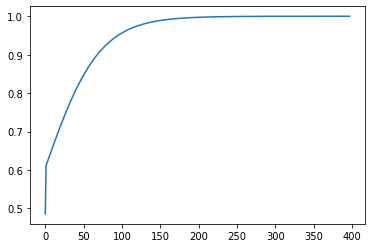

In [29]:
plt.plot(u[:,1])

In [30]:
trial.alpha

0.2

In [31]:
import matplotlib.pyplot as plt
import time
from matplotlib import animation

def animation(U, timeSteps: int, postionSteps: int, timeStepSize: float):

    fig= plt.figure()
    ims = []
    for i in range(timeSteps):
        im = plt.plot(postionSteps, U[:,i] , animated = True, color = 'red')
        ims.append(im)
    ani = animation.ArtistAnimation(fig, ims, interval = (100*timeStepSize), blit = True)
    plt.show()

AttributeError: 'function' object has no attribute 'ArtistAnimation'

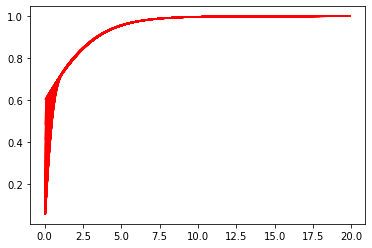

In [32]:
animation(u, trial.k_N, trial.x_range, trial.k)